# Transfer Learning on CIFAR-10: Complete Application

This notebook demonstrates modern transfer learning practices with PyTorch, showing:
- Training a simple CNN from scratch
- Using pretrained models (ResNet, EfficientNet)
- Data augmentation strategies
- Fine-tuning techniques

**Dataset**: CIFAR-10 (10 classes, 60k images)

In [1]:
# Installation (if needed)
# !pip install torch torchvision timm matplotlib

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision
import torchvision.transforms as transforms
from torchvision import models
import timm  # PyTorch Image Models - modern architectures
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import time

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

# Set seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

Using device: cuda


## 1. Data Preparation with Modern Augmentation

We use different augmentation strategies:
- **Basic**: Minimal augmentation for baseline
- **Strong**: Modern augmentations (RandomErasing, ColorJitter)

In [3]:
# CIFAR-10 classes
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# Basic augmentation
transform_basic_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616))
])

# Strong augmentation for pretrained models
transform_strong_train = transforms.Compose([
    transforms.Resize(224),  # Pretrained models expect 224x224
    transforms.RandomCrop(224, padding=28),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # ImageNet stats
    transforms.RandomErasing(p=0.3)
])

# Test transform (no augmentation)
transform_test = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

transform_test_basic = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616))
])

# Load datasets
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_strong_train)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)

# Create data loaders
train_loader = DataLoader(trainset, batch_size=128, shuffle=True, num_workers=2, pin_memory=True)
test_loader = DataLoader(testset, batch_size=128, shuffle=False, num_workers=2, pin_memory=True)

print(f'Training samples: {len(trainset)}')
print(f'Test samples: {len(testset)}')

100%|██████████| 170M/170M [00:02<00:00, 57.4MB/s]


Training samples: 50000
Test samples: 10000


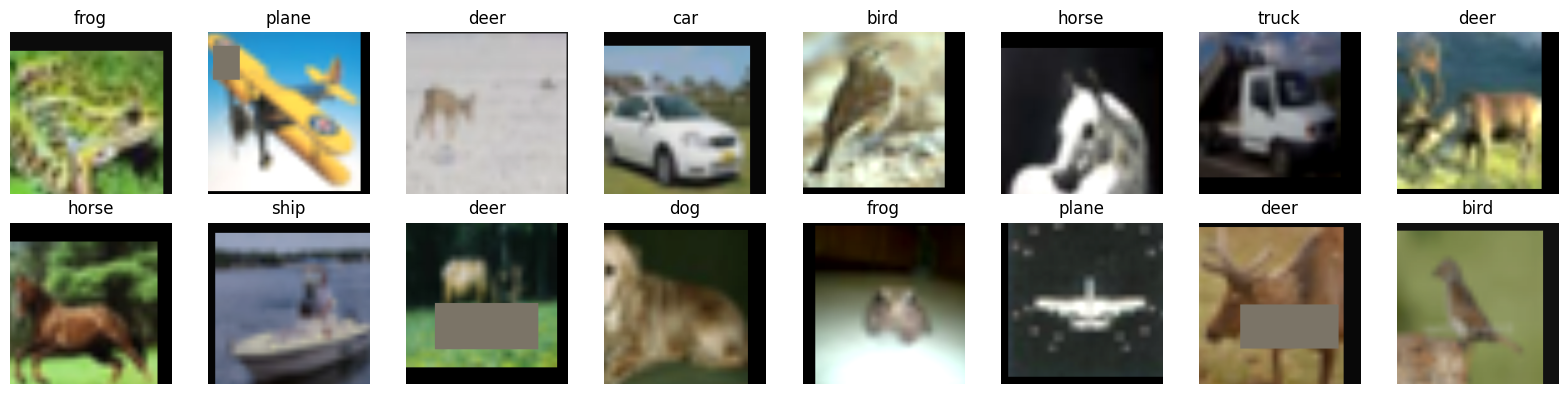

In [4]:
# Visualize some samples
def denormalize(tensor):
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
    return tensor * std + mean

# Show a batch
dataiter = iter(train_loader)
images, labels = next(dataiter)

fig, axes = plt.subplots(2, 8, figsize=(16, 4))
for idx, ax in enumerate(axes.flat):
    if idx < len(images):
        img = denormalize(images[idx].cpu())
        img = torch.clamp(img, 0, 1)
        ax.imshow(img.permute(1, 2, 0))
        ax.set_title(classes[labels[idx]])
    ax.axis('off')
plt.tight_layout()
plt.show()

## 2. Training Utilities

In [5]:
def train_one_epoch(model, loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    pbar = tqdm(loader, desc='Training')
    for inputs, labels in pbar:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

        pbar.set_postfix({'loss': f'{running_loss/len(pbar):.3f}', 'acc': f'{100.*correct/total:.2f}%'})

    return running_loss / len(loader), 100. * correct / total

def evaluate(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in tqdm(loader, desc='Evaluating'):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    return running_loss / len(loader), 100. * correct / total

def train_model(model, train_loader, test_loader, epochs, lr, name):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=0.01)
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)

    history = {'train_loss': [], 'train_acc': [], 'test_loss': [], 'test_acc': []}
    best_acc = 0

    print(f'\nTraining {name}')
    print('=' * 70)

    for epoch in range(epochs):
        print(f'\nEpoch {epoch+1}/{epochs}')

        train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer, device)
        test_loss, test_acc = evaluate(model, test_loader, criterion, device)

        scheduler.step()

        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['test_loss'].append(test_loss)
        history['test_acc'].append(test_acc)

        print(f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%')
        print(f'Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.2f}%')

        if test_acc > best_acc:
            best_acc = test_acc
            torch.save(model.state_dict(), f'{name}_best.pth')

    print(f'\nBest Test Accuracy: {best_acc:.2f}%')
    return history

## 3. Baseline: Simple CNN from Scratch

Train a compact CNN to establish baseline performance.

In [6]:
class SimpleCNN(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(64, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(128, 256, 3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d(1)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Dropout(0.5),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        return self.classifier(x)

# For baseline, use 32x32 images
trainset_basic = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_basic_train)
testset_basic = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test_basic)

train_loader_basic = DataLoader(trainset_basic, batch_size=128, shuffle=True, num_workers=2)
test_loader_basic = DataLoader(testset_basic, batch_size=128, shuffle=False, num_workers=2)

model_scratch = SimpleCNN().to(device)
print(f'Parameters: {sum(p.numel() for p in model_scratch.parameters()):,}')

history_scratch = train_model(model_scratch, train_loader_basic, test_loader_basic, epochs=20, lr=0.001, name='SimpleCNN')

Parameters: 374,282

Training SimpleCNN

Epoch 1/20


Evaluating: 100%|██████████| 79/79 [00:01<00:00, 60.53it/s]


Train Loss: 1.5516, Train Acc: 42.94%
Test Loss: 1.4087, Test Acc: 47.10%

Epoch 2/20


Evaluating: 100%|██████████| 79/79 [00:01<00:00, 65.21it/s]


Train Loss: 1.2677, Train Acc: 54.55%
Test Loss: 1.4172, Test Acc: 51.30%

Epoch 3/20


Evaluating: 100%|██████████| 79/79 [00:01<00:00, 58.00it/s]


Train Loss: 1.1638, Train Acc: 58.54%
Test Loss: 1.1531, Test Acc: 58.56%

Epoch 4/20


Evaluating: 100%|██████████| 79/79 [00:01<00:00, 61.90it/s]


Train Loss: 1.0974, Train Acc: 61.02%
Test Loss: 1.1436, Test Acc: 59.08%

Epoch 5/20


Evaluating: 100%|██████████| 79/79 [00:01<00:00, 63.38it/s]


Train Loss: 1.0470, Train Acc: 63.05%
Test Loss: 1.0775, Test Acc: 62.04%

Epoch 6/20


Evaluating: 100%|██████████| 79/79 [00:01<00:00, 59.26it/s]


Train Loss: 0.9974, Train Acc: 64.81%
Test Loss: 0.9187, Test Acc: 67.57%

Epoch 7/20


Evaluating: 100%|██████████| 79/79 [00:01<00:00, 62.50it/s]


Train Loss: 0.9610, Train Acc: 66.22%
Test Loss: 1.0907, Test Acc: 62.82%

Epoch 8/20


Evaluating: 100%|██████████| 79/79 [00:01<00:00, 64.11it/s]


Train Loss: 0.9216, Train Acc: 67.62%
Test Loss: 1.1501, Test Acc: 61.91%

Epoch 9/20


Evaluating: 100%|██████████| 79/79 [00:01<00:00, 61.94it/s]


Train Loss: 0.8905, Train Acc: 68.65%
Test Loss: 0.8568, Test Acc: 69.61%

Epoch 10/20


Evaluating: 100%|██████████| 79/79 [00:01<00:00, 62.69it/s]


Train Loss: 0.8654, Train Acc: 69.98%
Test Loss: 0.9265, Test Acc: 67.50%

Epoch 11/20


Evaluating: 100%|██████████| 79/79 [00:01<00:00, 61.83it/s]


Train Loss: 0.8344, Train Acc: 71.04%
Test Loss: 0.8571, Test Acc: 70.14%

Epoch 12/20


Evaluating: 100%|██████████| 79/79 [00:01<00:00, 64.73it/s]


Train Loss: 0.8147, Train Acc: 71.51%
Test Loss: 0.9254, Test Acc: 68.12%

Epoch 13/20


Evaluating: 100%|██████████| 79/79 [00:01<00:00, 63.75it/s]


Train Loss: 0.7913, Train Acc: 72.49%
Test Loss: 0.8105, Test Acc: 71.30%

Epoch 14/20


Evaluating: 100%|██████████| 79/79 [00:01<00:00, 59.92it/s]


Train Loss: 0.7710, Train Acc: 73.32%
Test Loss: 0.7593, Test Acc: 73.61%

Epoch 15/20


Evaluating: 100%|██████████| 79/79 [00:01<00:00, 64.00it/s]


Train Loss: 0.7575, Train Acc: 73.69%
Test Loss: 0.7623, Test Acc: 73.33%

Epoch 16/20


Evaluating: 100%|██████████| 79/79 [00:01<00:00, 63.84it/s]


Train Loss: 0.7434, Train Acc: 74.16%
Test Loss: 0.7321, Test Acc: 74.24%

Epoch 17/20


Evaluating: 100%|██████████| 79/79 [00:01<00:00, 62.64it/s]


Train Loss: 0.7274, Train Acc: 74.76%
Test Loss: 0.7052, Test Acc: 75.51%

Epoch 18/20


Evaluating: 100%|██████████| 79/79 [00:01<00:00, 63.17it/s]


Train Loss: 0.7184, Train Acc: 74.96%
Test Loss: 0.6786, Test Acc: 76.18%

Epoch 19/20


Evaluating: 100%|██████████| 79/79 [00:01<00:00, 63.84it/s]


Train Loss: 0.7161, Train Acc: 75.05%
Test Loss: 0.6707, Test Acc: 76.72%

Epoch 20/20


Evaluating: 100%|██████████| 79/79 [00:01<00:00, 64.24it/s]

Train Loss: 0.7120, Train Acc: 75.38%
Test Loss: 0.6653, Test Acc: 76.93%

Best Test Accuracy: 76.93%


## 4. Transfer Learning: ResNet18 (Frozen Backbone)

Use pretrained ResNet18 with frozen backbone, only train the classifier.

In [7]:
# Load pretrained ResNet18
model_resnet_frozen = models.resnet18(pretrained=True)

# Freeze all layers
for param in model_resnet_frozen.parameters():
    param.requires_grad = False

# Replace final layer
num_features = model_resnet_frozen.fc.in_features
model_resnet_frozen.fc = nn.Linear(num_features, 10)
model_resnet_frozen = model_resnet_frozen.to(device)

trainable_params = sum(p.numel() for p in model_resnet_frozen.parameters() if p.requires_grad)
total_params = sum(p.numel() for p in model_resnet_frozen.parameters())
print(f'Trainable: {trainable_params:,} / {total_params:,} ({100*trainable_params/total_params:.2f}%)')

history_resnet_frozen = train_model(model_resnet_frozen, train_loader, test_loader, epochs=10, lr=0.001, name='ResNet18_Frozen')

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 95.2MB/s]


Trainable: 5,130 / 11,181,642 (0.05%)

Training ResNet18_Frozen

Epoch 1/10


Evaluating: 100%|██████████| 79/79 [00:08<00:00,  9.16it/s]


Train Loss: 1.1024, Train Acc: 64.62%
Test Loss: 0.6891, Test Acc: 76.67%

Epoch 2/10


Evaluating: 100%|██████████| 79/79 [00:08<00:00,  9.03it/s]


Train Loss: 0.8294, Train Acc: 72.04%
Test Loss: 0.6504, Test Acc: 77.49%

Epoch 3/10


Evaluating: 100%|██████████| 79/79 [00:08<00:00,  9.14it/s]


Train Loss: 0.7856, Train Acc: 72.91%
Test Loss: 0.6173, Test Acc: 79.07%

Epoch 4/10


Evaluating: 100%|██████████| 79/79 [00:08<00:00,  9.04it/s]


Train Loss: 0.7712, Train Acc: 73.36%
Test Loss: 0.6096, Test Acc: 79.37%

Epoch 5/10


Evaluating: 100%|██████████| 79/79 [00:08<00:00,  9.22it/s]


Train Loss: 0.7555, Train Acc: 73.74%
Test Loss: 0.6013, Test Acc: 79.48%

Epoch 6/10


Evaluating: 100%|██████████| 79/79 [00:08<00:00,  9.24it/s]


Train Loss: 0.7482, Train Acc: 74.30%
Test Loss: 0.5910, Test Acc: 79.81%

Epoch 7/10


Evaluating: 100%|██████████| 79/79 [00:08<00:00,  9.22it/s]


Train Loss: 0.7422, Train Acc: 74.44%
Test Loss: 0.5921, Test Acc: 80.05%

Epoch 8/10


Evaluating: 100%|██████████| 79/79 [00:08<00:00,  9.20it/s]


Train Loss: 0.7317, Train Acc: 74.43%
Test Loss: 0.6049, Test Acc: 79.48%

Epoch 9/10


Evaluating: 100%|██████████| 79/79 [00:08<00:00,  9.21it/s]


Train Loss: 0.7355, Train Acc: 74.58%
Test Loss: 0.5942, Test Acc: 79.69%

Epoch 10/10


Evaluating: 100%|██████████| 79/79 [00:08<00:00,  9.11it/s]

Train Loss: 0.7300, Train Acc: 74.83%
Test Loss: 0.5901, Test Acc: 80.00%

Best Test Accuracy: 80.05%


## 5. Transfer Learning: ResNet18 (Full Fine-tuning)

Fine-tune all layers with lower learning rate.

In [8]:
# Load pretrained ResNet18
model_resnet_full = models.resnet18(pretrained=True)

# Replace final layer
model_resnet_full.fc = nn.Linear(model_resnet_full.fc.in_features, 10)
model_resnet_full = model_resnet_full.to(device)

print(f'Total parameters: {sum(p.numel() for p in model_resnet_full.parameters()):,}')

history_resnet_full = train_model(model_resnet_full, train_loader, test_loader, epochs=15, lr=0.0001, name='ResNet18_FullFinetune')

Total parameters: 11,181,642

Training ResNet18_FullFinetune

Epoch 1/15


Evaluating: 100%|██████████| 79/79 [00:08<00:00,  9.21it/s]


Train Loss: 0.4442, Train Acc: 85.37%
Test Loss: 0.2146, Test Acc: 92.48%

Epoch 2/15


Evaluating: 100%|██████████| 79/79 [00:08<00:00,  9.16it/s]


Train Loss: 0.2217, Train Acc: 92.56%
Test Loss: 0.1817, Test Acc: 93.83%

Epoch 3/15


Evaluating: 100%|██████████| 79/79 [00:08<00:00,  9.17it/s]


Train Loss: 0.1695, Train Acc: 94.33%
Test Loss: 0.1539, Test Acc: 94.89%

Epoch 4/15


Evaluating: 100%|██████████| 79/79 [00:08<00:00,  9.18it/s]


Train Loss: 0.1371, Train Acc: 95.46%
Test Loss: 0.1609, Test Acc: 94.91%

Epoch 5/15


Evaluating: 100%|██████████| 79/79 [00:08<00:00,  9.12it/s]


Train Loss: 0.1101, Train Acc: 96.29%
Test Loss: 0.1363, Test Acc: 95.52%

Epoch 6/15


Evaluating: 100%|██████████| 79/79 [00:08<00:00,  9.04it/s]


Train Loss: 0.0941, Train Acc: 96.87%
Test Loss: 0.1291, Test Acc: 95.63%

Epoch 7/15


Evaluating: 100%|██████████| 79/79 [00:08<00:00,  9.17it/s]


Train Loss: 0.0825, Train Acc: 97.23%
Test Loss: 0.1338, Test Acc: 95.60%

Epoch 8/15


Evaluating: 100%|██████████| 79/79 [00:08<00:00,  9.15it/s]


Train Loss: 0.0685, Train Acc: 97.76%
Test Loss: 0.1294, Test Acc: 95.91%

Epoch 9/15


Evaluating: 100%|██████████| 79/79 [00:08<00:00,  9.10it/s]


Train Loss: 0.0582, Train Acc: 98.17%
Test Loss: 0.1226, Test Acc: 96.17%

Epoch 10/15


Evaluating: 100%|██████████| 79/79 [00:08<00:00,  9.22it/s]


Train Loss: 0.0560, Train Acc: 98.13%
Test Loss: 0.1178, Test Acc: 96.23%

Epoch 11/15


Evaluating: 100%|██████████| 79/79 [00:08<00:00,  9.08it/s]


Train Loss: 0.0475, Train Acc: 98.47%
Test Loss: 0.1103, Test Acc: 96.50%

Epoch 12/15


Evaluating: 100%|██████████| 79/79 [00:08<00:00,  9.07it/s]


Train Loss: 0.0426, Train Acc: 98.67%
Test Loss: 0.1107, Test Acc: 96.56%

Epoch 13/15


Evaluating: 100%|██████████| 79/79 [00:08<00:00,  9.21it/s]


Train Loss: 0.0377, Train Acc: 98.83%
Test Loss: 0.1095, Test Acc: 96.63%

Epoch 14/15


Evaluating: 100%|██████████| 79/79 [00:08<00:00,  9.11it/s]


Train Loss: 0.0388, Train Acc: 98.70%
Test Loss: 0.1047, Test Acc: 96.70%

Epoch 15/15


Evaluating: 100%|██████████| 79/79 [00:08<00:00,  9.03it/s]

Train Loss: 0.0370, Train Acc: 98.85%
Test Loss: 0.1057, Test Acc: 96.73%

Best Test Accuracy: 96.73%


## 6. Modern Architecture: EfficientNet-B0

Use a modern, efficient architecture from the `timm` library.

In [9]:
# Load pretrained EfficientNet-B0
model_efficientnet = timm.create_model('efficientnet_b0', pretrained=True, num_classes=10)
model_efficientnet = model_efficientnet.to(device)

print(f'Total parameters: {sum(p.numel() for p in model_efficientnet.parameters()):,}')

history_efficientnet = train_model(model_efficientnet, train_loader, test_loader, epochs=15, lr=0.0001, name='EfficientNet_B0')

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/21.4M [00:00<?, ?B/s]

Total parameters: 4,020,358

Training EfficientNet_B0

Epoch 1/15


Evaluating: 100%|██████████| 79/79 [00:09<00:00,  8.07it/s]


Train Loss: 0.6221, Train Acc: 80.56%
Test Loss: 0.2417, Test Acc: 92.36%

Epoch 2/15


Evaluating: 100%|██████████| 79/79 [00:09<00:00,  8.73it/s]


Train Loss: 0.2244, Train Acc: 92.53%
Test Loss: 0.1715, Test Acc: 94.38%

Epoch 3/15


Evaluating: 100%|██████████| 79/79 [00:08<00:00,  9.06it/s]


Train Loss: 0.1463, Train Acc: 94.93%
Test Loss: 0.1485, Test Acc: 95.01%

Epoch 4/15


Evaluating: 100%|██████████| 79/79 [00:08<00:00,  9.01it/s]


Train Loss: 0.1076, Train Acc: 96.30%
Test Loss: 0.1326, Test Acc: 95.79%

Epoch 5/15


Evaluating: 100%|██████████| 79/79 [00:08<00:00,  9.04it/s]


Train Loss: 0.0838, Train Acc: 97.14%
Test Loss: 0.1265, Test Acc: 96.06%

Epoch 6/15


Evaluating: 100%|██████████| 79/79 [00:08<00:00,  8.88it/s]


Train Loss: 0.0689, Train Acc: 97.63%
Test Loss: 0.1309, Test Acc: 96.19%

Epoch 7/15


Evaluating: 100%|██████████| 79/79 [00:08<00:00,  8.95it/s]


Train Loss: 0.0599, Train Acc: 98.03%
Test Loss: 0.1242, Test Acc: 96.22%

Epoch 8/15


Evaluating: 100%|██████████| 79/79 [00:08<00:00,  8.82it/s]


Train Loss: 0.0532, Train Acc: 98.17%
Test Loss: 0.1227, Test Acc: 96.51%

Epoch 9/15


Evaluating: 100%|██████████| 79/79 [00:08<00:00,  8.99it/s]


Train Loss: 0.0443, Train Acc: 98.49%
Test Loss: 0.1170, Test Acc: 96.72%

Epoch 10/15


Evaluating: 100%|██████████| 79/79 [00:08<00:00,  9.04it/s]


Train Loss: 0.0423, Train Acc: 98.58%
Test Loss: 0.1178, Test Acc: 96.79%

Epoch 11/15


Evaluating: 100%|██████████| 79/79 [00:08<00:00,  9.09it/s]


Train Loss: 0.0394, Train Acc: 98.70%
Test Loss: 0.1161, Test Acc: 96.84%

Epoch 12/15


Evaluating: 100%|██████████| 79/79 [00:08<00:00,  9.09it/s]


Train Loss: 0.0336, Train Acc: 98.88%
Test Loss: 0.1132, Test Acc: 96.75%

Epoch 13/15


Evaluating: 100%|██████████| 79/79 [00:08<00:00,  8.90it/s]


Train Loss: 0.0339, Train Acc: 98.93%
Test Loss: 0.1130, Test Acc: 96.85%

Epoch 14/15


Evaluating: 100%|██████████| 79/79 [00:08<00:00,  8.86it/s]


Train Loss: 0.0329, Train Acc: 98.96%
Test Loss: 0.1122, Test Acc: 96.91%

Epoch 15/15


Evaluating: 100%|██████████| 79/79 [00:08<00:00,  8.96it/s]

Train Loss: 0.0327, Train Acc: 98.96%
Test Loss: 0.1111, Test Acc: 96.86%

Best Test Accuracy: 96.91%


## 7. Comparison and Analysis

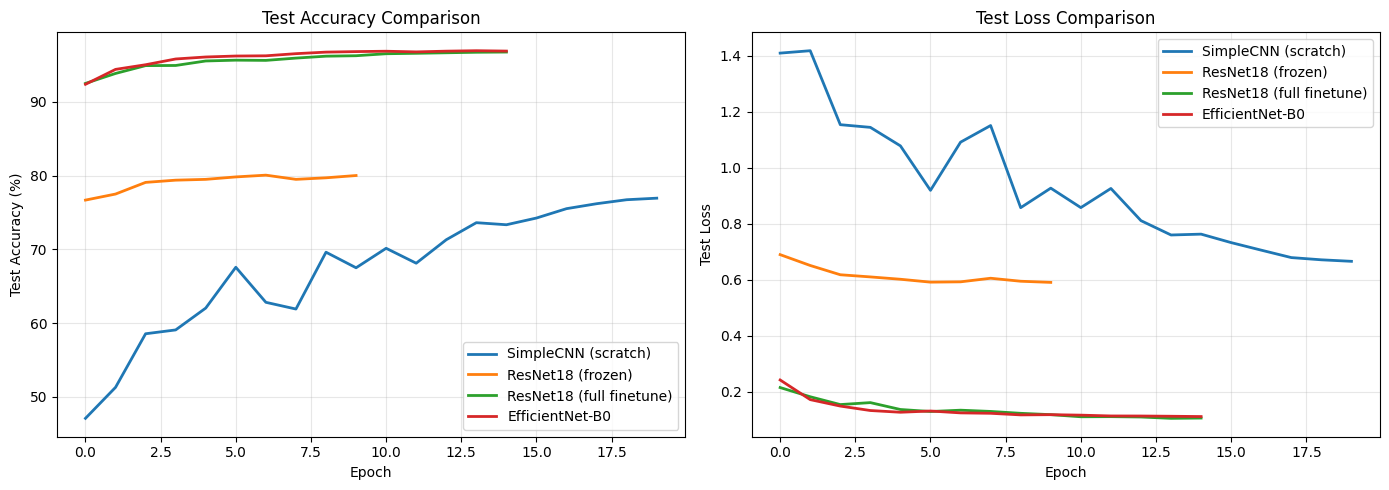


Final Test Accuracy:
SimpleCNN (scratch)           : 76.93%
ResNet18 (frozen)             : 80.00%
ResNet18 (full finetune)      : 96.73%
EfficientNet-B0               : 96.86%


In [10]:
# Plot comparison
histories = [
    (history_scratch, 'SimpleCNN (scratch)'),
    (history_resnet_frozen, 'ResNet18 (frozen)'),
    (history_resnet_full, 'ResNet18 (full finetune)'),
    (history_efficientnet, 'EfficientNet-B0')
]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

for history, label in histories:
    ax1.plot(history['test_acc'], label=label, linewidth=2)
    ax2.plot(history['test_loss'], label=label, linewidth=2)

ax1.set_xlabel('Epoch')
ax1.set_ylabel('Test Accuracy (%)')
ax1.set_title('Test Accuracy Comparison')
ax1.legend()
ax1.grid(True, alpha=0.3)

ax2.set_xlabel('Epoch')
ax2.set_ylabel('Test Loss')
ax2.set_title('Test Loss Comparison')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print final results
print('\nFinal Test Accuracy:')
print('=' * 50)
for history, label in histories:
    print(f'{label:30s}: {history["test_acc"][-1]:.2f}%')